In [40]:
#ИМПОРТИРУЕМ БИБЛИОТЕКИ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
#ПОДГРУЖАЕМ БИБЛИОТЕКИ ДЛЯ ОБУЧЕНИЯ МОДЕЛИ
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

In [42]:
#ПОДГРУЖАЕМ ДАННЫЕ
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [43]:
#СОЕДИНЯЕМ ДАННЫЕ, ВПОСЛЕДСТВИИ РАЗЪЕДИНИМ ДЛЯ ОБУЧЕНИЯ И ВАЛИДАЦИИ
all_data = pd.concat([train_df.drop(['Id'], axis=1), test_df.drop('Id', axis=1)], ignore_index=True)

In [44]:
#ВЫВОДИМ ПРИЗНАКИ С ПРОПУСКАМИ
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [45]:
#ОБНАРУЖИВАЕМ ЧТО У НЕКОТОРЫХ ПРИЗНАКОВ ОБИЛЬНОЕ КОЛИЧЕСТВО ПРОПУСКОВ, ВЫВОДИМ ЗНАЧЕНИЕ ПРОПУСКОВ
for col in all_data.columns:
    print (f'{col} : {train_df[col].isna().sum()}')

MSSubClass : 0
MSZoning : 0
LotFrontage : 259
LotArea : 0
Street : 0
Alley : 1369
LotShape : 0
LandContour : 0
Utilities : 0
LotConfig : 0
LandSlope : 0
Neighborhood : 0
Condition1 : 0
Condition2 : 0
BldgType : 0
HouseStyle : 0
OverallQual : 0
OverallCond : 0
YearBuilt : 0
YearRemodAdd : 0
RoofStyle : 0
RoofMatl : 0
Exterior1st : 0
Exterior2nd : 0
MasVnrType : 872
MasVnrArea : 8
ExterQual : 0
ExterCond : 0
Foundation : 0
BsmtQual : 37
BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinSF1 : 0
BsmtFinType2 : 38
BsmtFinSF2 : 0
BsmtUnfSF : 0
TotalBsmtSF : 0
Heating : 0
HeatingQC : 0
CentralAir : 0
Electrical : 1
1stFlrSF : 0
2ndFlrSF : 0
LowQualFinSF : 0
GrLivArea : 0
BsmtFullBath : 0
BsmtHalfBath : 0
FullBath : 0
HalfBath : 0
BedroomAbvGr : 0
KitchenAbvGr : 0
KitchenQual : 0
TotRmsAbvGrd : 0
Functional : 0
Fireplaces : 0
FireplaceQu : 690
GarageType : 81
GarageYrBlt : 81
GarageFinish : 81
GarageCars : 0
GarageArea : 0
GarageQual : 81
GarageCond : 81
PavedDrive : 0
WoodDeckSF : 0
Op

In [46]:
#УДАЛЯЕМ ПРИЗНАКИ С БОЛЕЕ ЧЕМ 50% ПРОПУСКАМИ
cols_to_drop = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
all_data = all_data.drop(cols_to_drop, axis=1)

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

In [48]:
#РАСПРЕДЕЛЯЕМ НА ВЕЩЕСТВЕННЫЕ И КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ. НАЧИНАЕМ РАБОТАТЬ С КАЖДОЙ КАТЕГОРИЕЙ ПО ОТДЕЛЬНОСТИ
categorical_cols = all_data.select_dtypes(include=['object'])
print(categorical_cols)

     MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave      IR1         Lvl    AllPub       FR2       Gtl   
...       ...    ...      ...         ...       ...       ...       ...   
2914       RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
2915       RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
2916       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
2917       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
2918       RL   Pave      Reg         Lvl    AllPub    Inside       Mod   

     Neighborhood Condition1 Condition2  ... Electrical KitchenQual  \
0         CollgCr       Norm

In [49]:
numerical_cols = all_data.select_dtypes(include=['int64', 'float64'])
print(numerical_cols)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
2914         160         21.0     1936            4            7       1970   
2915         160         21.0     1894            4            5       1970   
2916          20        160.0    20000            5            7       1960   
2917          85         62.0    10441            5            5       1992   
2918          60         74.0     9627            7            5       1993   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [50]:
train_len = len(numerical_cols)
y_train = numerical_cols['SalePrice'].copy()

In [51]:
train_numeric = numerical_cols.iloc[:train_len].copy()
train_numeric['SalePrice'] = y_train

In [52]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

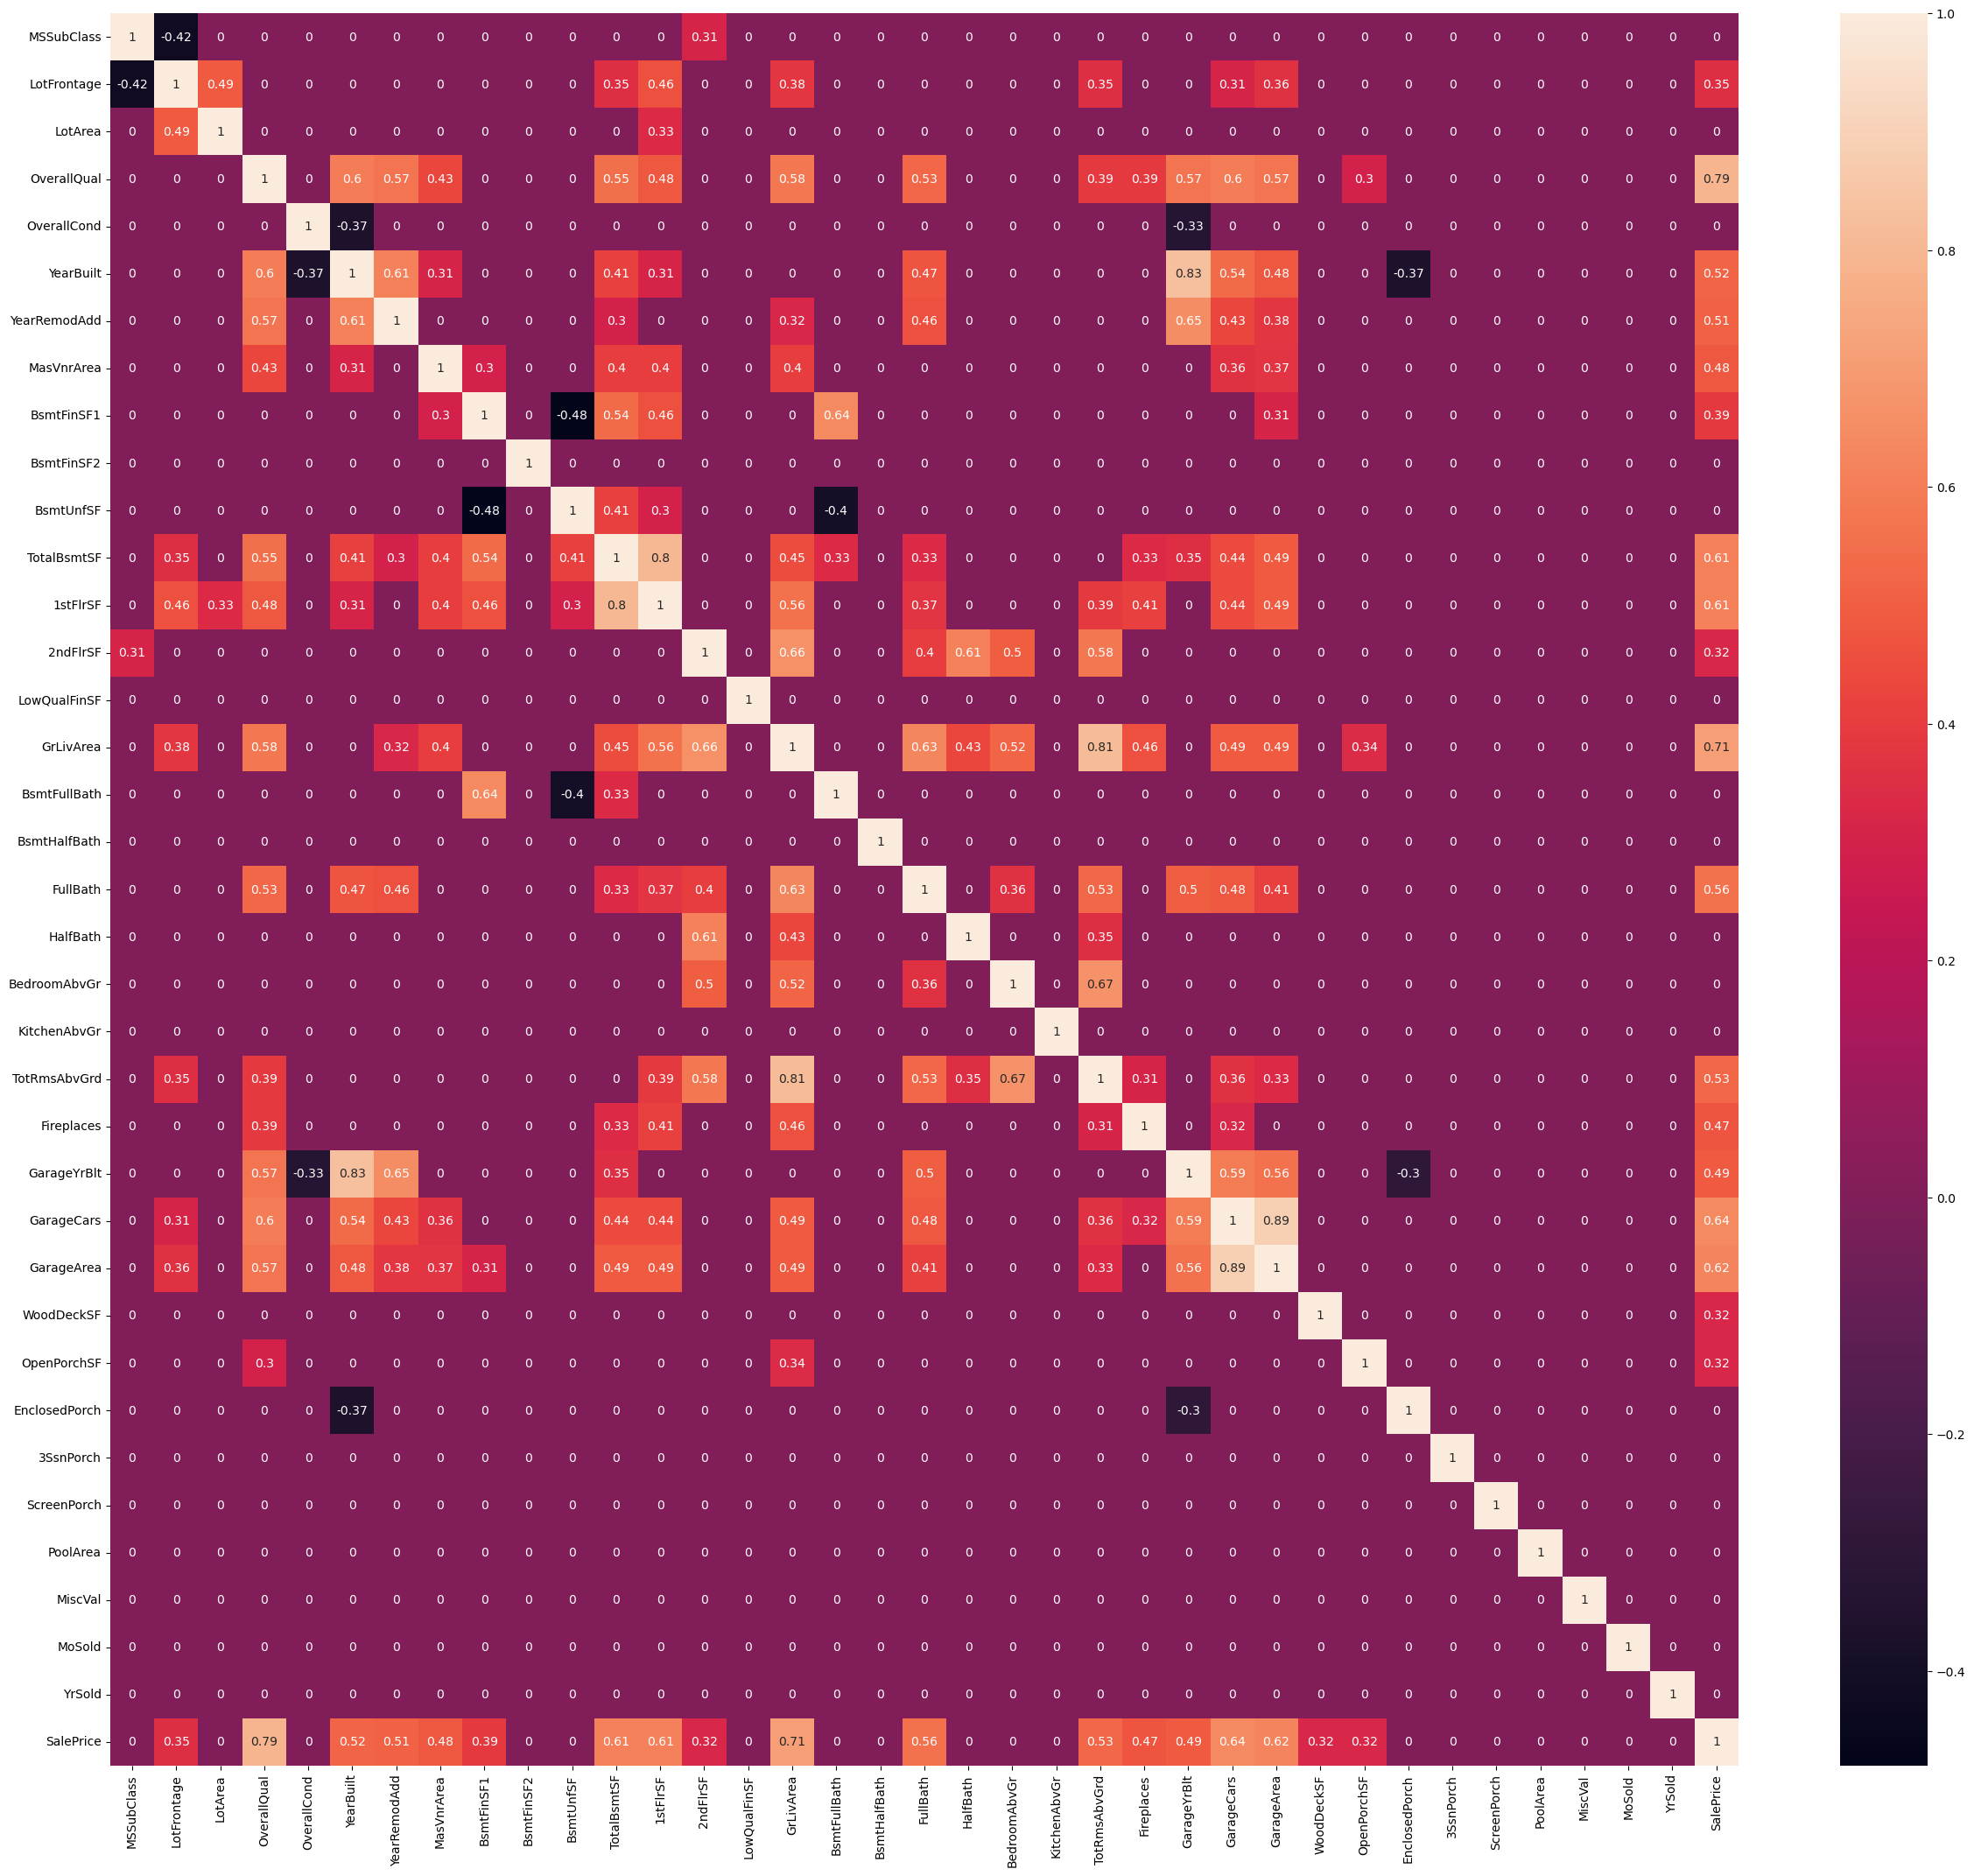

In [53]:
#ФОРМИРУЕМ МАТРИЦУ КОРРЕЛЯЦИИ ДЛЯ ВЕЩЕСТВЕННЫХ ПРИЗНАКОВ
#ОКРУГЛЯЕМ ДО ВТОРОГО ЗНАКА ПОСЛЕ ЗАПЯТОЙ И ЗАНУЛЯЕМ ЕСЛИ % КОРРЕЛЯЦИИ МЕНЬШЕ 0.3
#ИСПОЛЬЗУЕМ ЭТО ДЛЯ СНИЖЕНИЯ РАЗМЕРНОСТИ И ПРОСТОТЫ ВЫЯВЛЕНИЯ ВЗАИМНЫХ КОРРЕЛЯЦИЙ
corr_matrix_full = train_numeric.corr()
corr_for_plot = corr_matrix_full.round(2).copy()
corr_for_plot[abs(corr_for_plot) < 0.3] = 0

plt.figure(figsize=(30, 26))
sns.heatmap(corr_for_plot, annot=True)
plt.show()

In [54]:
corr_matrix = train_numeric.corr()
corr_with_price = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_with_price.head(10))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


In [55]:
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr1 = abs(corr_with_price.get(col1, 0))
            corr2 = abs(corr_with_price.get(col2, 0))
            high_corr_pairs.append((col1, col2, corr_matrix.iloc[i,j], corr1, corr2))

In [56]:
to_drop = ['GarageCars', '1stFlrSF', 'TotRmsAbvGrd', '2ndFlrSF']

print("Пары с корреляцией > 0.8")
for pair in high_corr_pairs:
    print(pair)

Пары с корреляцией > 0.8
('YearBuilt', 'GarageYrBlt', np.float64(0.8348123731631011), np.float64(0.5228973328794967), np.float64(0.4863616774878596))
('TotalBsmtSF', '1stFlrSF', np.float64(0.8016699703092834), np.float64(0.6135805515591943), np.float64(0.6058521846919153))
('GrLivArea', 'TotRmsAbvGrd', np.float64(0.8083544205418535), np.float64(0.7086244776126515), np.float64(0.5337231555820284))
('GarageCars', 'GarageArea', np.float64(0.8897004146858484), np.float64(0.6404091972583519), np.float64(0.6234314389183622))


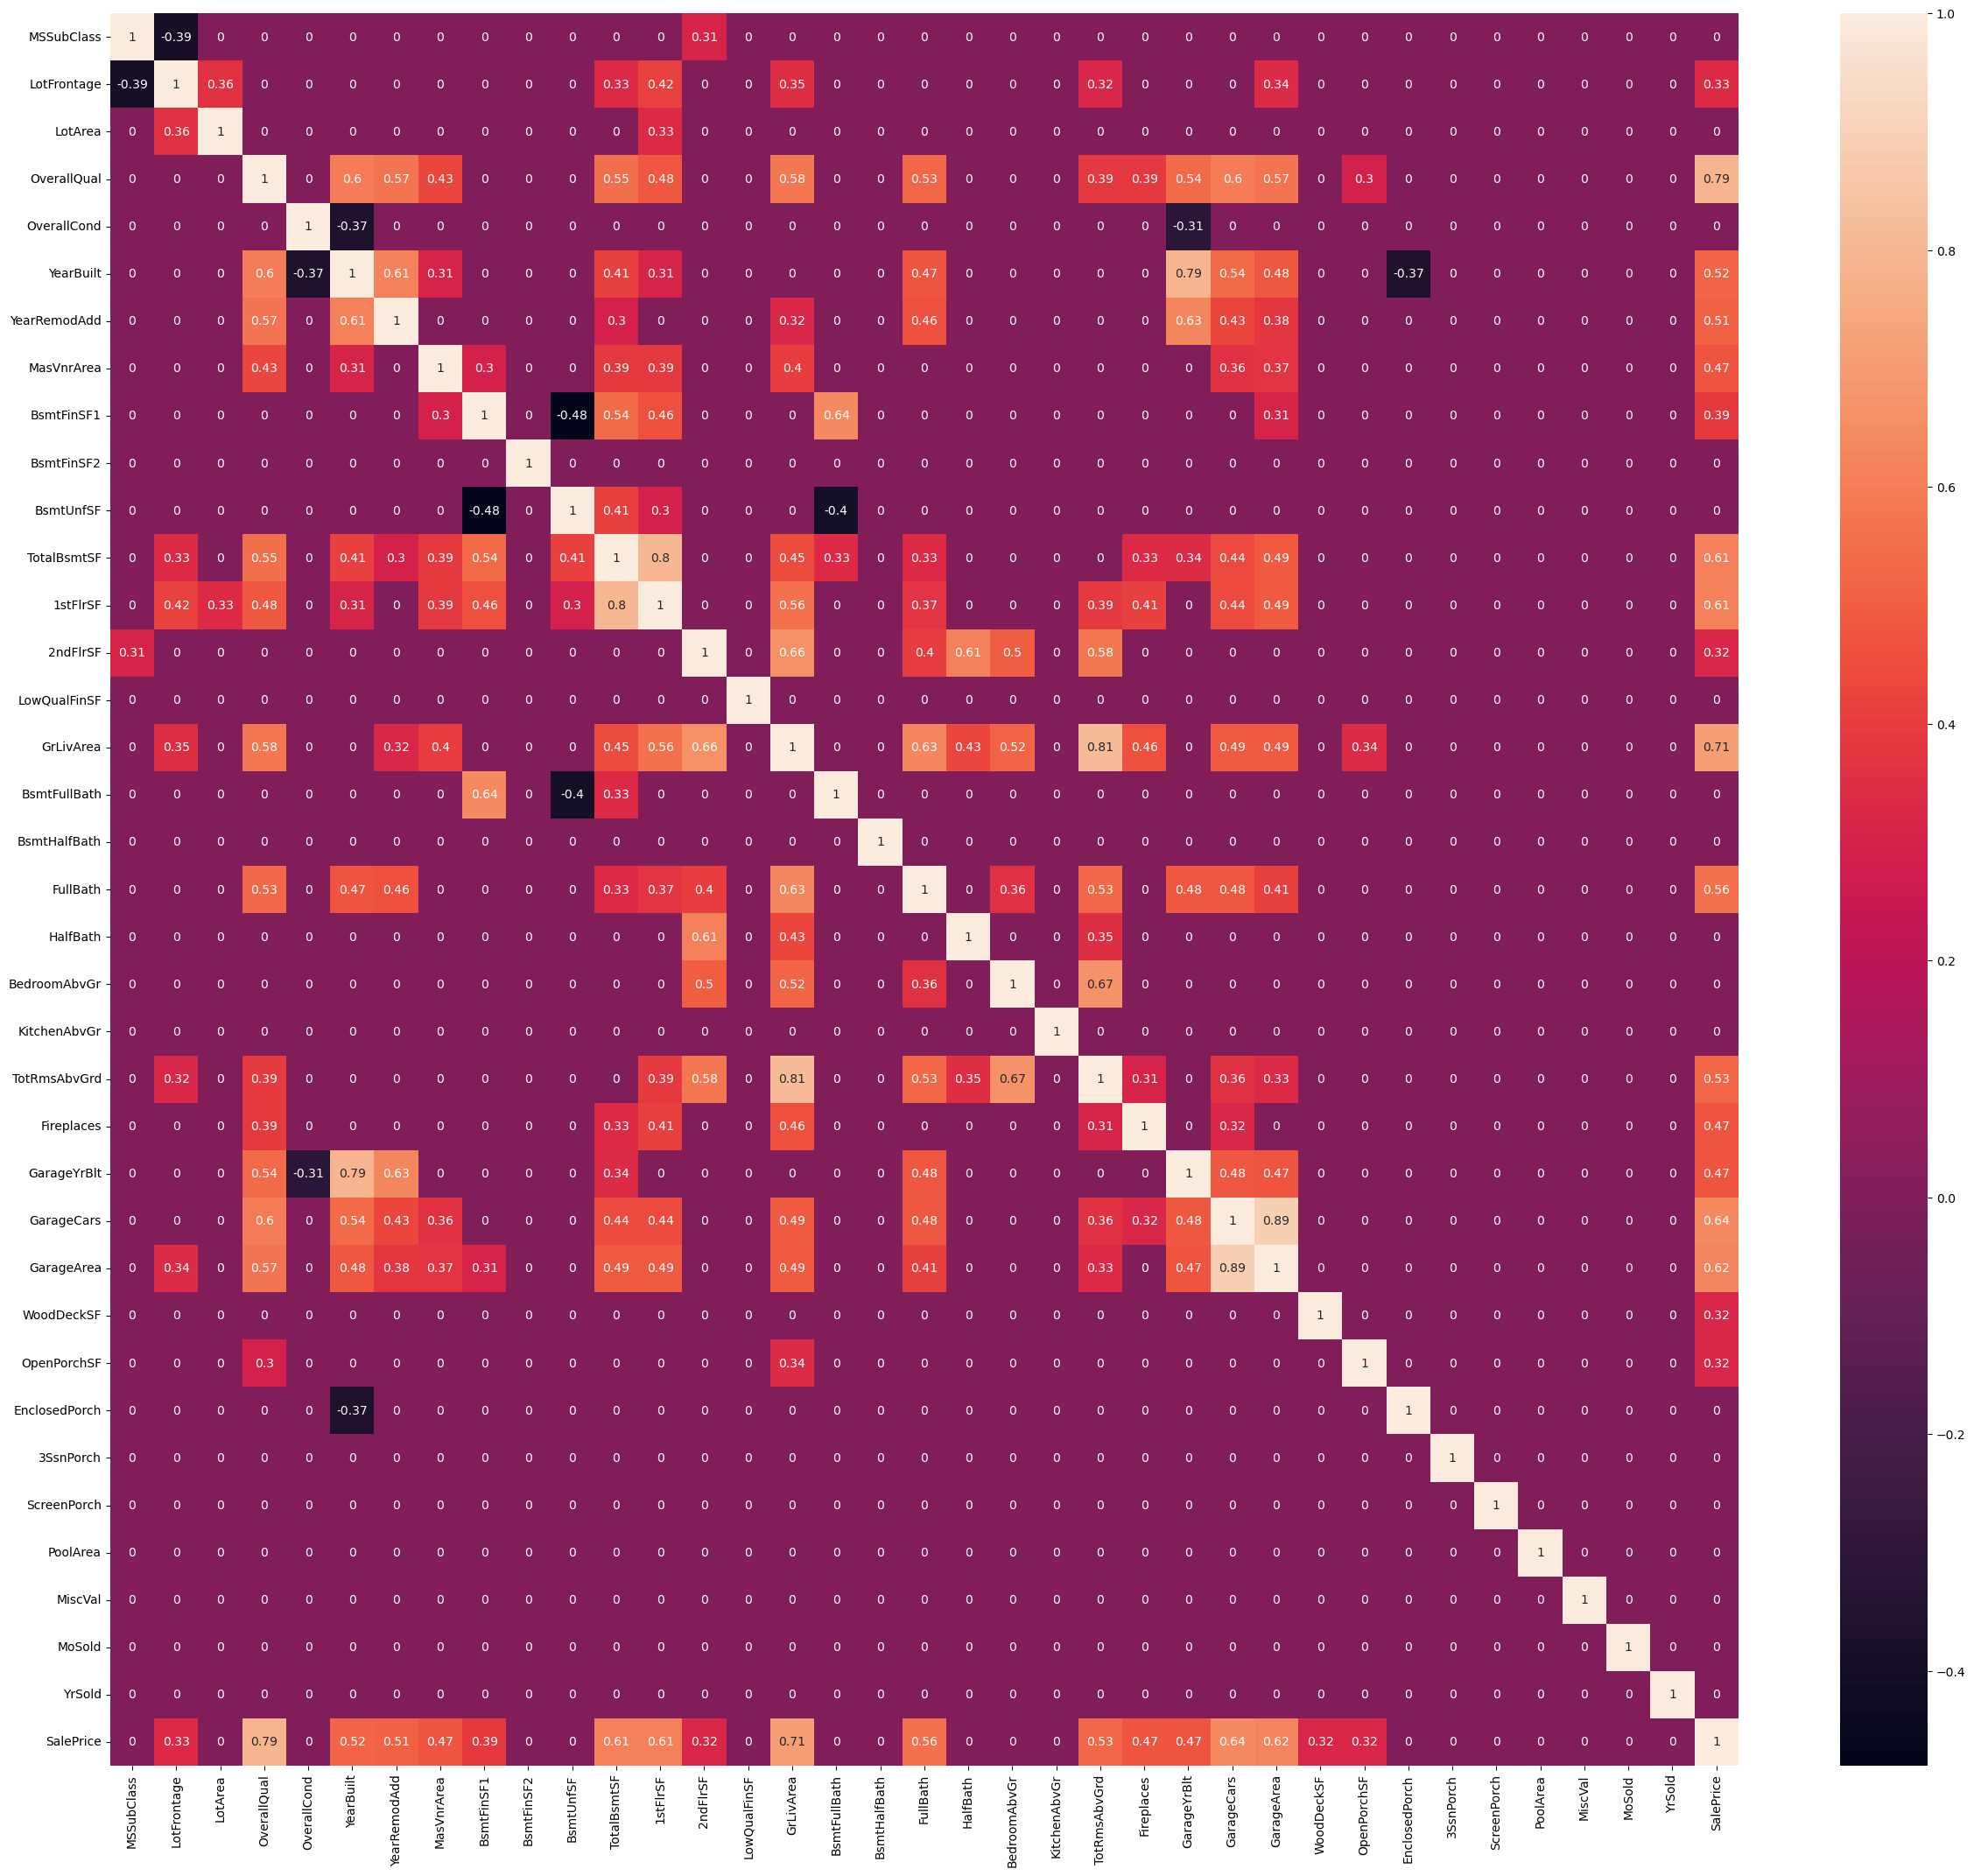

In [57]:
numeric_data_updated = all_data.select_dtypes(include=['int64', 'float64', 'uint8', 'int32'])

train_numeric_updated = numeric_data_updated.iloc[:train_len].copy()
train_numeric_updated['SalePrice'] = y_train  # y_train у вас уже сохранён

corr_matrix_new = train_numeric_updated.corr()

corr_for_plot_new = corr_matrix_new.round(2).copy()
corr_for_plot_new[abs(corr_for_plot_new) < 0.3] = 0

plt.figure(figsize=(30, 26))
sns.heatmap(corr_for_plot_new, annot=True)
plt.show()

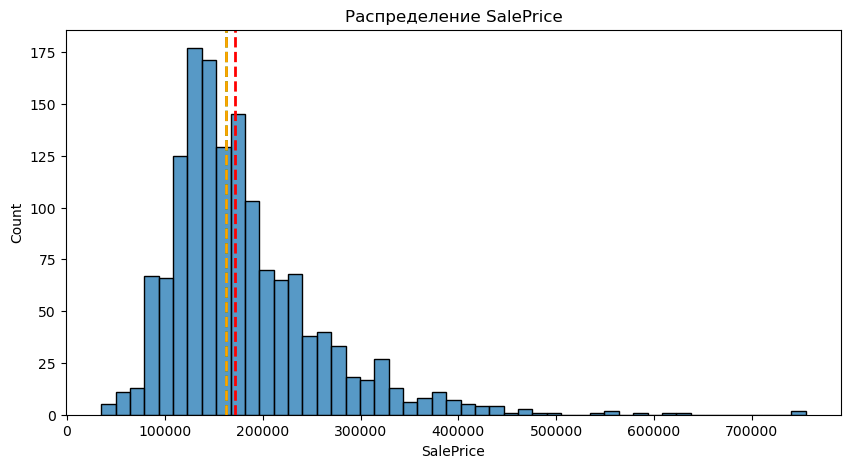

In [58]:
all_data_mean = all_data['SalePrice'].mean()
all_data_median = all_data['SalePrice'].median()
all_data_mode = all_data['SalePrice'].mode()[0]
most_correlation_feature = corr_matrix['SalePrice'].sort_values(ascending=False)[1:11].index.tolist()

plt.figure(figsize=(10, 5))
sns.histplot(train_df['SalePrice'])
plt.axvline(all_data_mean, color='red', linestyle= '--', linewidth=2)
plt.axvline(all_data_median, color='green', linestyle= '--',  linewidth=2)
plt.axvline(all_data_mode, color='orange', linestyle= '--',  linewidth=2)
#МОДА И МЕДИАНА НА ГРАФИКЕ НАХОДЯТСЯ В ОДНОЙ ТОЧКЕ
plt.title('Распределение SalePrice')
plt.show()

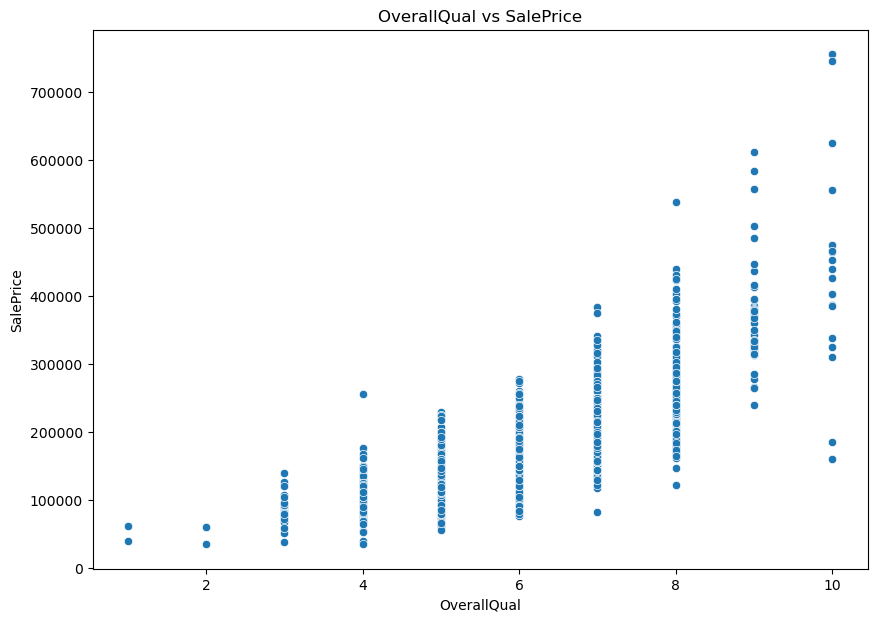

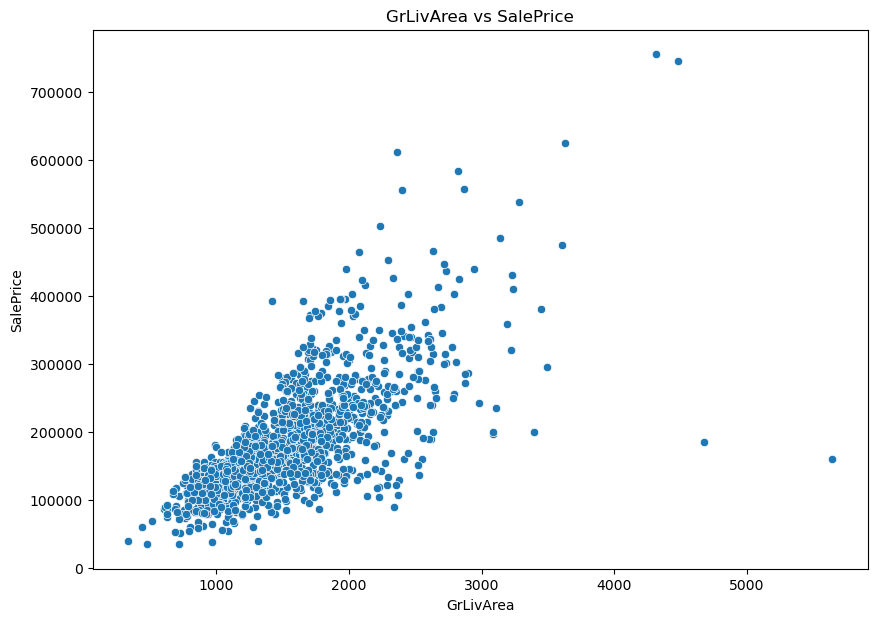

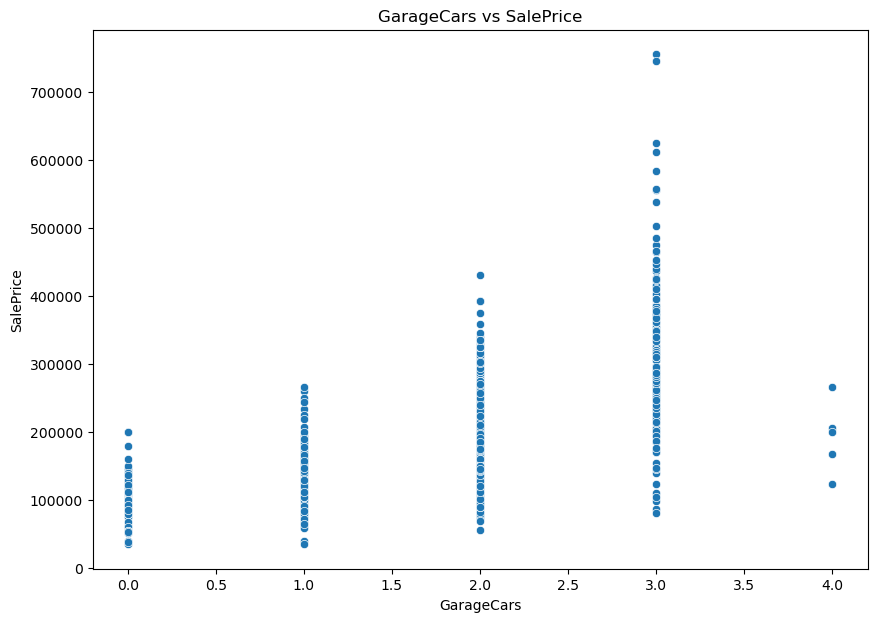

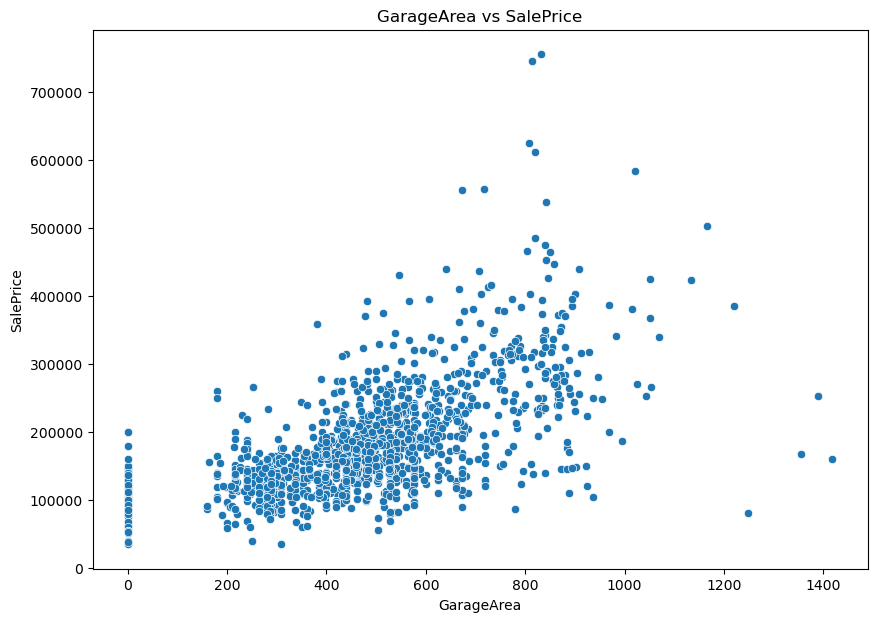

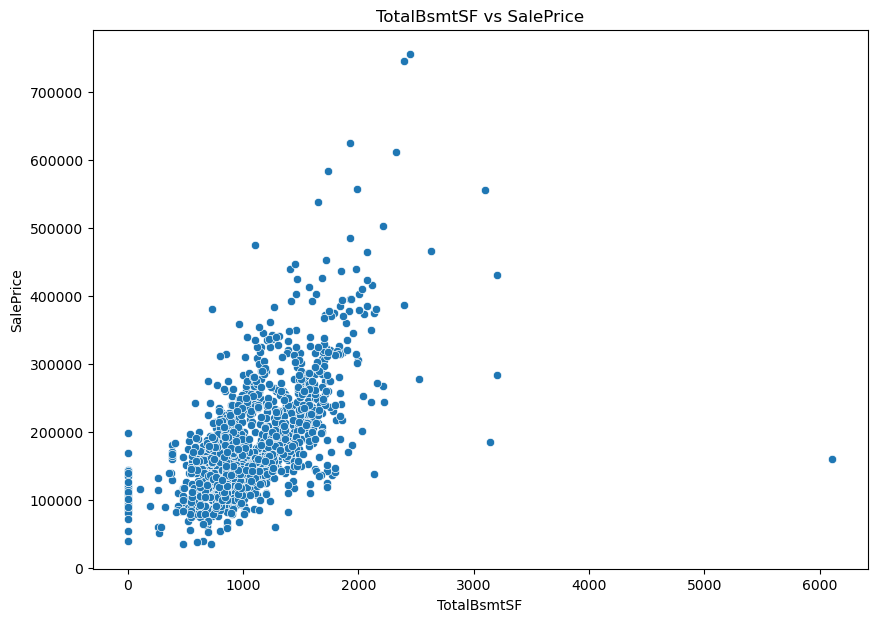

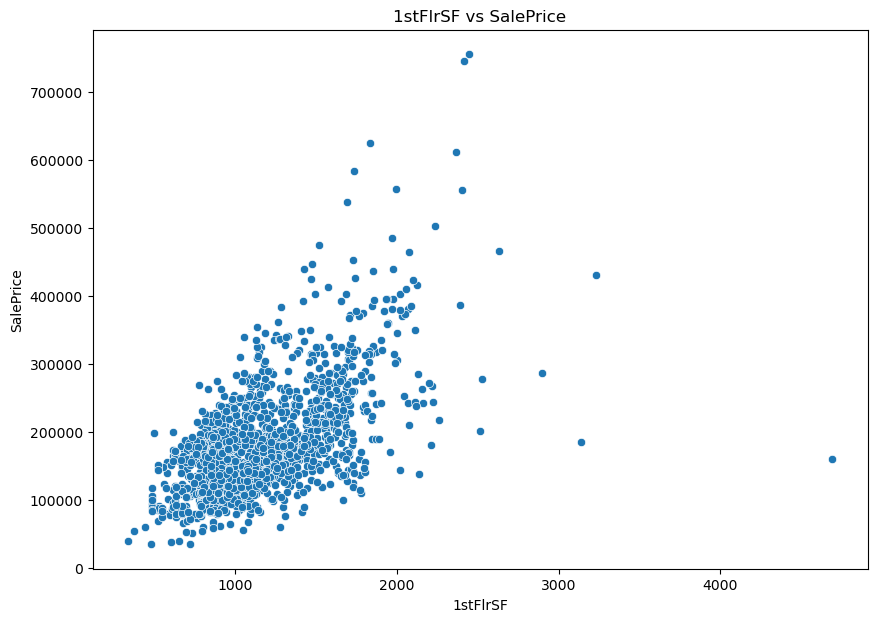

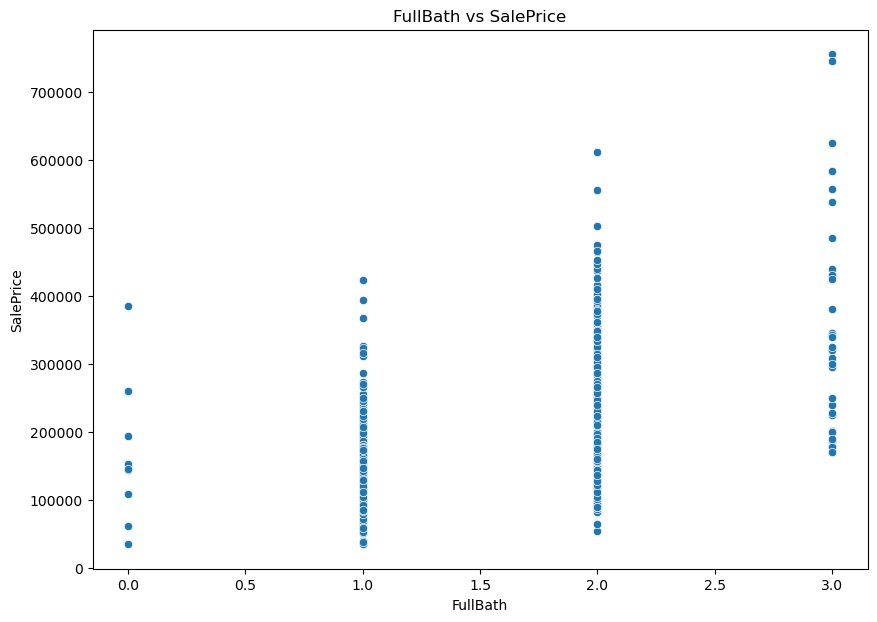

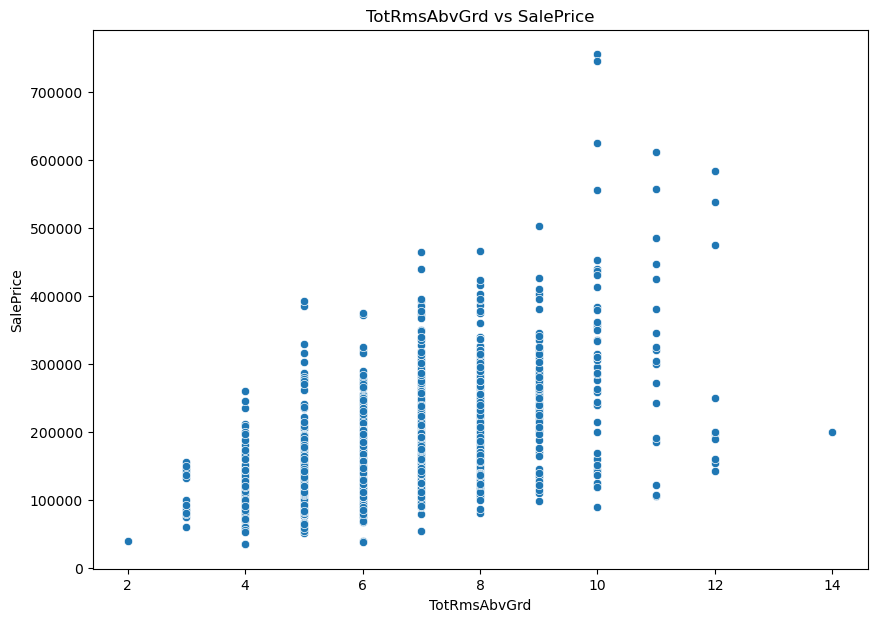

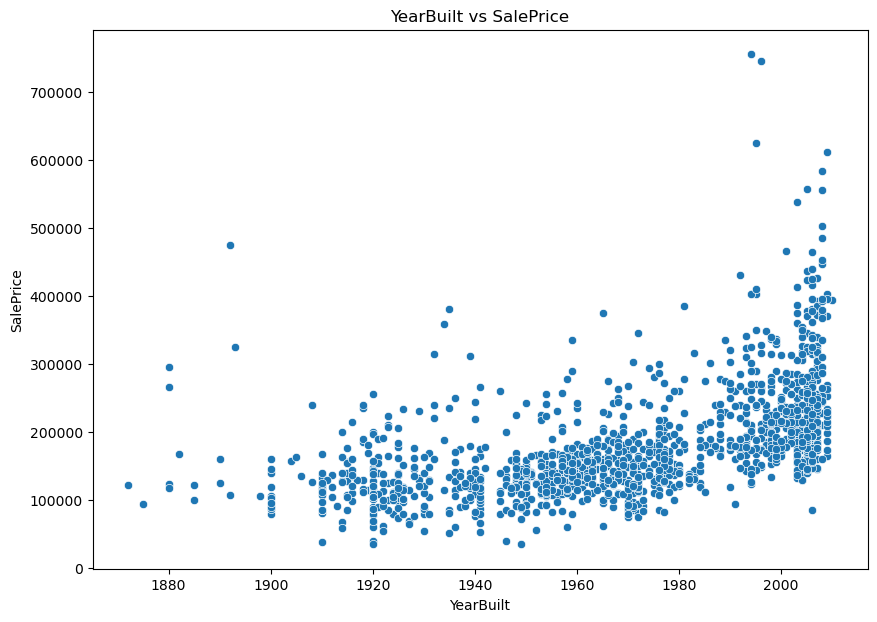

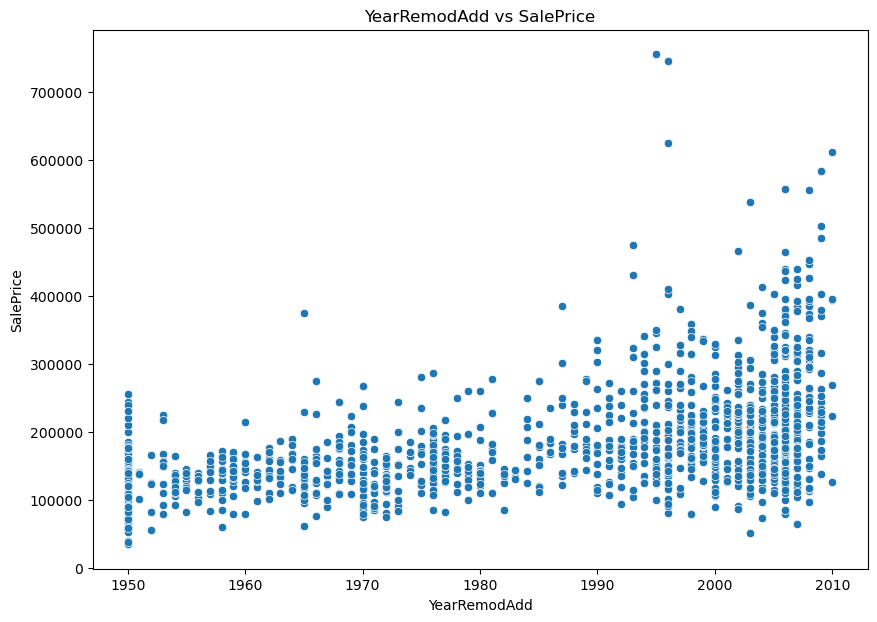

In [59]:
for feature in most_correlated_features:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=all_data[feature][:train_len], y=train_df['SalePrice'])
    plt.title(f'{feature} vs SalePrice')
    plt.show()

In [ ]:
# Порядковые признаки и их порядок (от худшего к лучшему)
ordinal_mappings = {
    'ExterQual':     {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond':     {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtQual':      {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond':      {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtExposure':  {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'BsmtFinType1':  {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'BsmtFinType2':  {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'HeatingQC':     {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'KitchenQual':   {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageQual':    {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond':    {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageFinish':  {'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
    'PavedDrive':    {'N':0, 'P':1, 'Y':2},
    'Functional':    {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7},
    'LotShape':      {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3},
    'LandSlope':     {'Sev':0, 'Mod':1, 'Gtl':2},
    'CentralAir':    {'N':0, 'Y':1},
}

for col, mapping in ordinal_mappings.items():
    all_data[col] = all_data[col].map(mapping)

In [ ]:

nominal_cols = all_data.select_dtypes(include='object').columns

# One-hot encoding
all_data = pd.get_dummies(all_data, columns=nominal_cols, drop_first=True, dtype=int)

In [ ]:
train_len = len(train_df)
X_train = all_data[:train_len].copy()
X_test  = all_data[train_len:].copy()

# Удаляем SalePrice из X_train (если он там остался)
if 'SalePrice' in X_train.columns:
    y_train = X_train['SalePrice']
    X_train = X_train.drop('SalePrice', axis=1)
else:
    y_train = y

In [64]:
#ДЛЯ ОБУЧЕНИЯ ИСПОЛЬЗУЕМ МЕТОД АНСАМБЛИРОВАНИЯ (КОГДА ИСПОЛЬЗУЕМ НЕСКОЛЬКО МОДЕЛЕЙ И ВЫБИРАЕТ ОДНУ ИЗ НИХ)
#БЫЛИ ВЫБРАНЫ МОДЕЛИ L2,L1 РЕГУЛЯРИЗАЦИИ, ELASTIC.NET, RANDOMFOREST И XGBOOST, CATBOOST, LightGBOOST
#Т.К. ЛИНЕЙНЫЕ МОДЕЛИ УЛАВЛИВАЮТ ВЗАИМОСВЯЗИ А RANDOMFOREST УСТОЙЧИВ К ШУМУ В ДАННЫХ ПОЭТОМУ ВЫБОР ПАЛ НА ЭТИ МОДЕЛИ
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, 
    y_train,  # явно указываем размер валидации
    random_state=42  # для воспроизводимости
)

base_models = [
    ('ridge', Ridge(alpha=10.0)),
    ('lasso', Lasso(alpha=0.001, max_iter=10000)),
    ('elastic', ElasticNet(alpha=0.001, l1_ratio=0.7)),
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ('lgb', LGBMRegressor(n_estimators=3000, learning_rate=0.01, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42, force_row_wise=True)),
    ('cat', CatBoostRegressor(iterations=3000, learning_rate=0.01, depth=3, subsample=0.8, random_state=42, verbose=0))
]


In [65]:
#ОБУЧАЕМ МЕТА МОДЕЛЬ (L2 РЕГУЛЯРИЗАЦИЯ) С ПОМОЩЬЮ K-FOLD (ВЗЯЛИ ЧИСЛО 5)
#СОЗДАЕМ МАТРИЦУ ИЗ ДАННЫХ ПОСЛЕ ОБУЧЕНИЯ НА КАЖДОЙ base_model
#НА ВТОРОМ УРОВНЕ ОБУЧАЕМ Ridge, ПОЛУЧАЕМ ИТОГОВОЕ ЗНАЧЕНИЕ ОШИБКИ
meta_model = Ridge(alpha=1.0)

# Стэкинг с 5-fold CV
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Проверка на CV
stacked_model.fit(X_train, y_train)

,estimators,"[('ridge', ...), ('lasso', ...), ...]"
,final_estimator,Ridge()
,cv,5
,n_jobs,-1
,passthrough,False
,verbose,1
,alpha,10.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [67]:
#ТЕСТИРУЕМ ОБУЧЕННУЮ МОДЕЛЬ И ВЫВОДИМ ПРЕДПОЛОЖЕНИЯ ДЛЯ ТАБЛИЦЫ submission
#ЗАГРУЖАЕМ ТАБЛИЦУ НА KAGGLE
#РЕЗУЛЬТАТ 0.12721, 1440 МЕСТО НА KAGGLE
X_test = X_test.drop('SalePrice', axis=1)
preds_log = stacked_model.predict(X_test)
preds_price = np.clip(preds_log)

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': preds_price
})

submission.to_csv('submission.csv', index=False)
print(submission.head())

     Id      SalePrice
0  1461  119082.844570
1  1462  160633.280652
2  1463  181656.409549
3  1464  188332.974364
4  1465  188397.486620
